In [75]:
print(__doc__)

import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
from sklearn.datasets.samples_generator import make_blobs
import random

import warnings
warnings.filterwarnings("ignore")

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def mutate(x, y):
    mutate_x = random.randint(0, max(y))
    while x == mutate_x:
        mutate_x = randint(0, max(y))
    return mutate_x
        

def noise(y, N):
    size_noise = int(round(len(y)*N))
    num_classes = max(y)+1
    index_noise = np.random.choice(np.arange(len(y)), size=size_noise, replace=False)
    y_noise = [mutate(y[i_x],y) if i_x in index_noise else y[i_x] for i_x in range(len(y))]
    return np.array(y_noise)


    

Automatically created module for IPython interactive environment


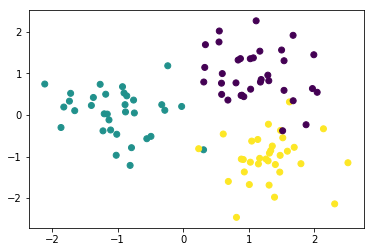

In [105]:
centers = [[1, 1], [-1, 0], [1, -1]]
std=0.6

X_train, y_train = make_blobs(n_samples=100,centers=centers, cluster_std=std,
                            random_state=1)
plt.scatter(X_train[:,0],X_train[:,1], c=y_train)

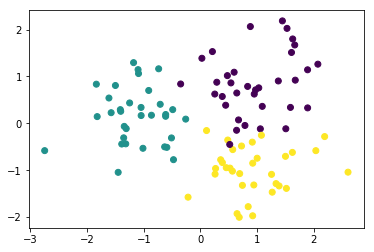

In [68]:
X_test, y_test = make_blobs(n_samples=100,centers=centers, cluster_std=std,
                            random_state=3)
plt.scatter(X_test[:,0],X_test[:,1], c=y_test)

In [145]:
def show_noise_effect(X_train, y_train, X_test=None, y_test=None, N_max=0.35, step=0.10, gamma=0, reg_lambda=1, reg_alpha=0):
    random.seed(1)
    np.random.seed(1)
    noise_levels = list(np.round(np.arange(0, N_max+step, step=step),2))
    noise_y_set = [noise(y_train, N) for  N in noise_levels]
    models = [ xgb.XGBClassifier(gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha).fit(X_train, y_train) for y_train in noise_y_set  ]

    # title for the plots
    titles = [f'Ruido al {N*100:.2f}%' for N in noise_levels ]

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(2, 3)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax, y_train in zip(models, titles, sub.flatten(), noise_y_set):
        y_pred = clf.predict(X_train)
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(f'X0\nAcc: {accuracy_score(y_train, y_pred)*100:.2f}%')
        ax.set_ylabel('X1')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
    plt.suptitle(f'XGB gamma={gamma} [Training]')    
    plt.savefig(f'./summary_train_{gamma}_{reg_lambda}_{reg_alpha}.png')

   
    for clf, title, ax, noise_level, y_train in zip(models, titles, sub.flatten(), noise_levels, noise_y_set):
            y_pred = clf.predict(X_train)
            
            big_fig, big_sub = plt.subplots(1, 1)
            plot_contours(big_sub, clf, xx, yy,
                          cmap=plt.cm.coolwarm, alpha=0.8)
            big_sub.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
            big_sub.set_xlim(xx.min(), xx.max())
            big_sub.set_ylim(yy.min(), yy.max())
            big_sub.set_xlabel(f'X0\nAcc: {accuracy_score(y_train, y_pred)*100:.2f}%')
            big_sub.set_ylabel('X1')
            big_sub.set_xticks(())
            big_sub.set_yticks(())
            big_sub.set_title(title)
            plt.savefig(f'./{noise_level:.2f}_train_{gamma}_{reg_lambda}_{reg_alpha}.png')
    
    if(X_test is not None and y_test is not None):
        
        # Set-up 2x2 grid for plotting.
        fig, sub = plt.subplots(2, 3)
        plt.subplots_adjust(wspace=0.4, hspace=0.6)
        
        X0, X1 = X_test[:, 0], X_test[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        
        for clf, title, ax, noise_level in zip(models, titles, sub.flatten(), noise_levels):
            y_pred = clf.predict(X_test)
            plot_contours(ax, clf, xx, yy,
                          cmap=plt.cm.coolwarm, alpha=0.8)
            ax.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xlabel(f'X0\nAcc: {accuracy_score(y_test, y_pred)*100:.2f}%')
            ax.set_ylabel('X1')
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_title(title)
        plt.suptitle(f'XGB gamma={gamma} [Test]')    
        plt.savefig(f'./summary_test_{gamma}_{reg_lambda}_{reg_alpha}.png')

    
        for clf, title, ax, noise_level in zip(models, titles, sub.flatten(), noise_levels):
            y_pred = clf.predict(X_test)
            
            big_fig, big_sub = plt.subplots(1, 1)
            plot_contours(big_sub, clf, xx, yy,
                          cmap=plt.cm.coolwarm, alpha=0.8)
            big_sub.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
            big_sub.set_xlim(xx.min(), xx.max())
            big_sub.set_ylim(yy.min(), yy.max())
            big_sub.set_xlabel(f'X0\nAcc: {accuracy_score(y_test, y_pred)*100:.2f}%')
            big_sub.set_ylabel('X1')
            big_sub.set_xticks(())
            big_sub.set_yticks(())
            big_sub.set_title(title)
            plt.savefig(f'./{noise_level:.2f}_test_{gamma}_{reg_lambda}_{reg_alpha}.png')
            


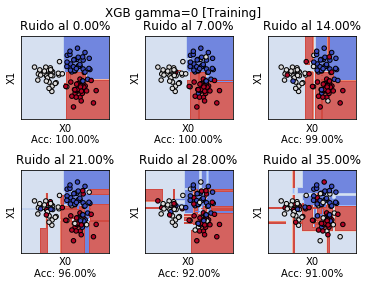

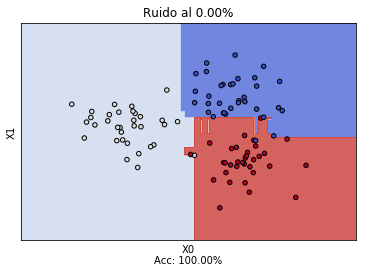

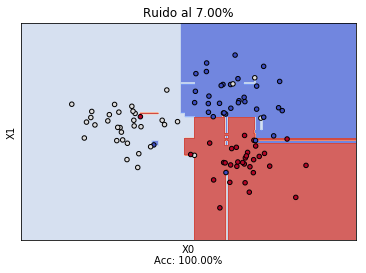

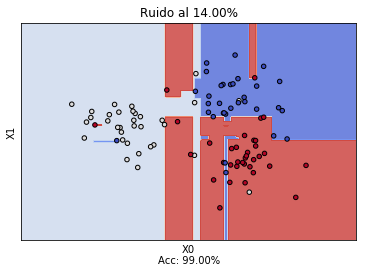

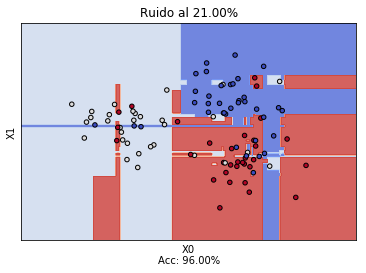

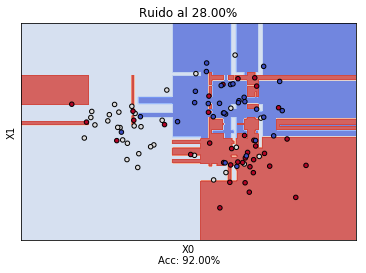

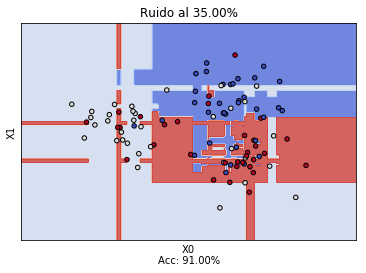

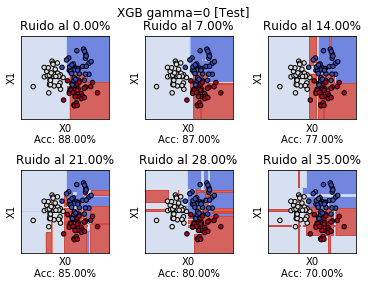

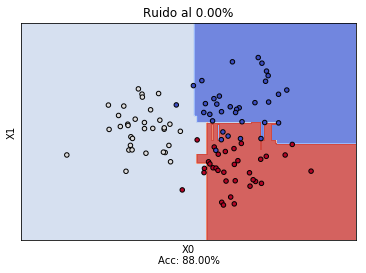

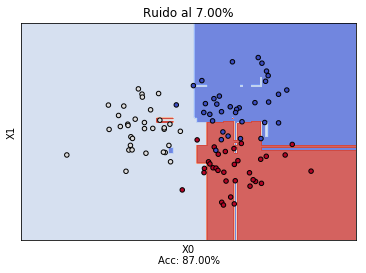

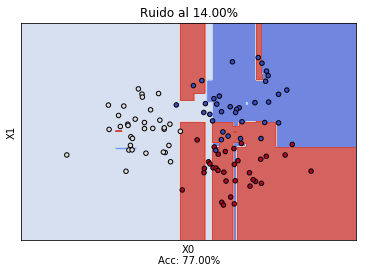

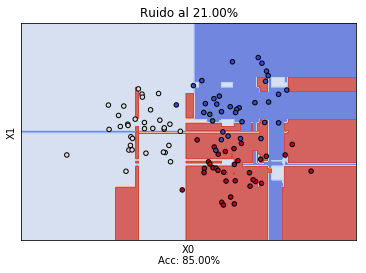

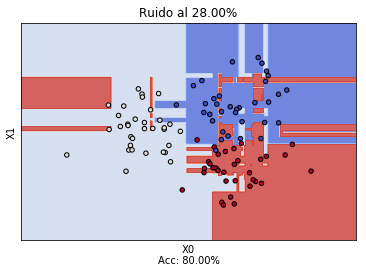

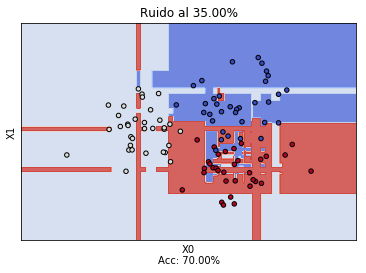

In [146]:
show_noise_effect(X_train, y_train, X_test, y_test, N_max=0.3, step=0.07, gamma=0)

[0.0, 0.07, 0.14, 0.21, 0.28, 0.35]


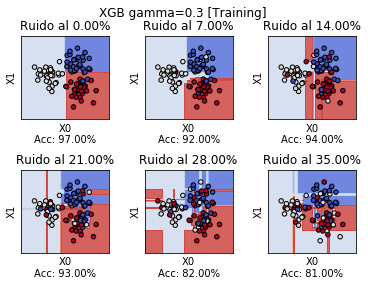

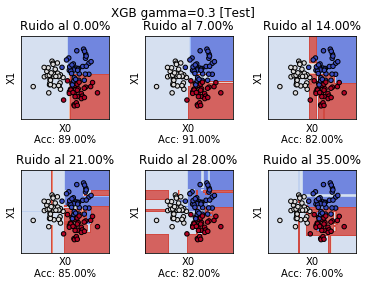

In [108]:
show_noise_effect(X_train, y_train, X_test, y_test, N_max=0.3, step=0.07, gamma=0.3)

[0.0, 0.07, 0.14, 0.21, 0.28, 0.35]


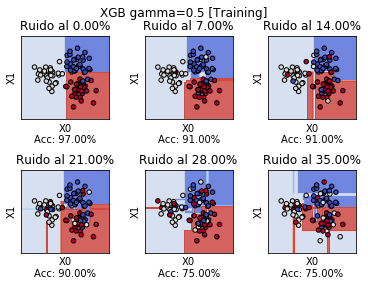

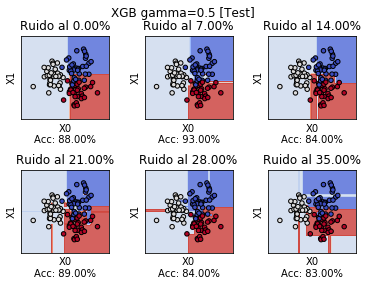

In [109]:
show_noise_effect(X_train, y_train, X_test, y_test, N_max=0.3, step=0.07, gamma=0.5)

[0.0, 0.07, 0.14, 0.21, 0.28, 0.35]


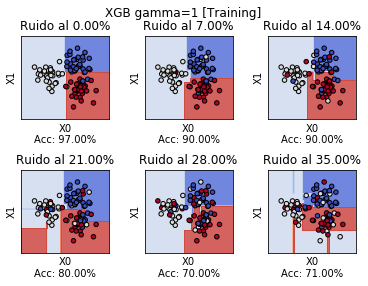

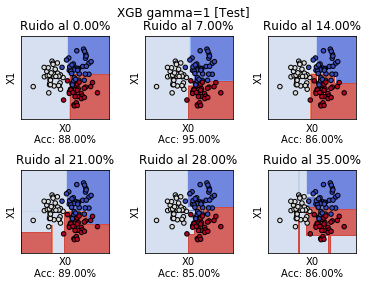

In [110]:
show_noise_effect(X_train, y_train, X_test, y_test, N_max=0.3, step=0.07, gamma=1)

## Summary

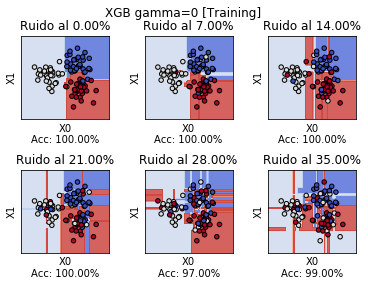

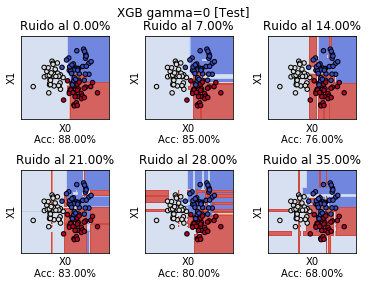

In [121]:
show_noise_effect(X_train, y_train, X_test, y_test, N_max=0.3, step=0.07, gamma=0, reg_lambda=0, reg_alpha=0)

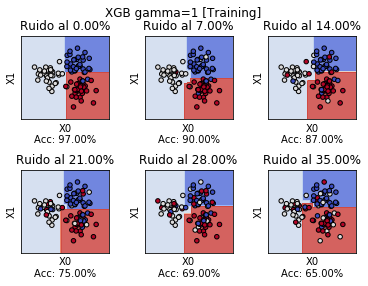

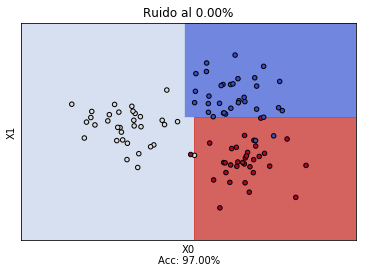

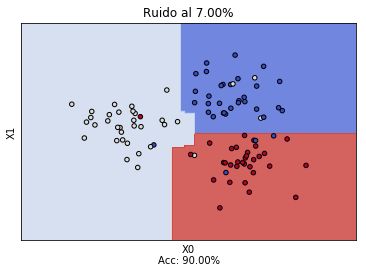

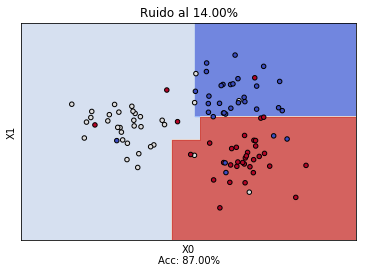

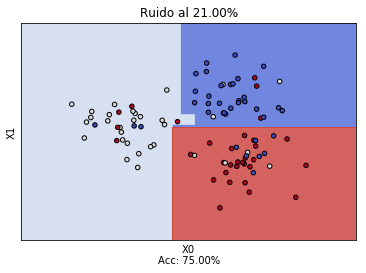

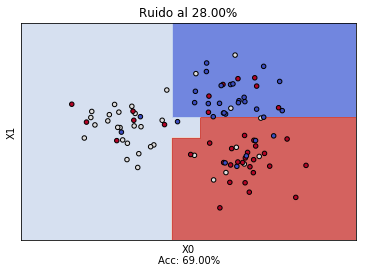

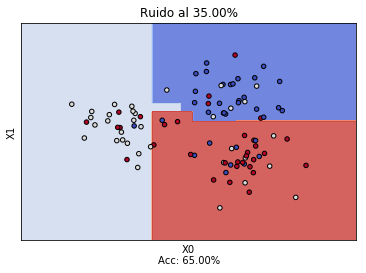

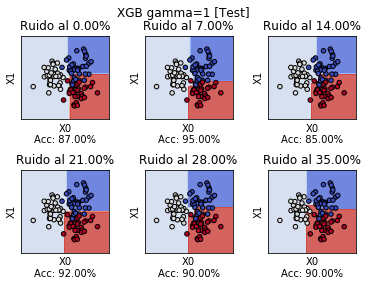

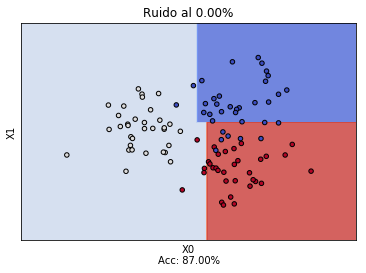

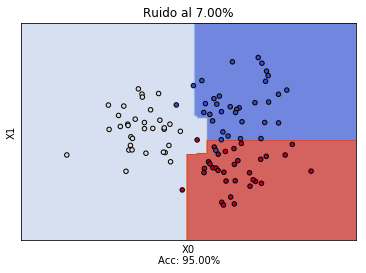

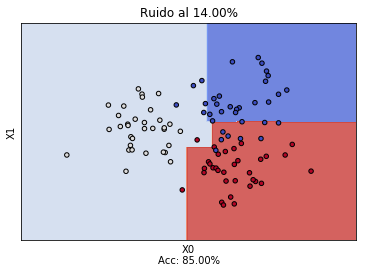

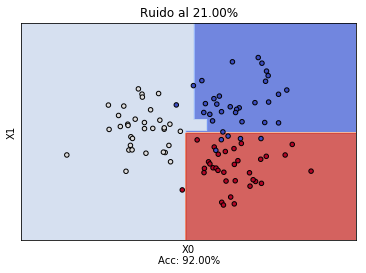

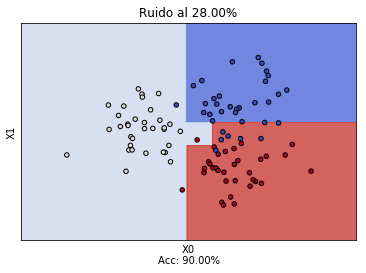

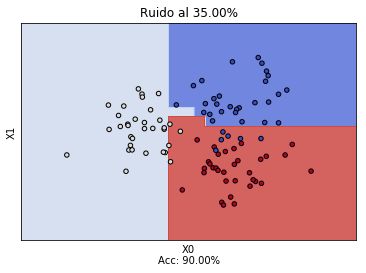

In [147]:
show_noise_effect(X_train, y_train, X_test, y_test, N_max=0.3, step=0.07, gamma=1, reg_lambda=5)